In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ijson
import seaborn as sns

In [2]:
def compute_speed(timestamps, x_positions, y_positions):
    """
    Computes speed in km/h from position and time data.

    Args:
        timestamps (np.ndarray): Array of timestamps in seconds.
        x_positions (np.ndarray): Array of x positions in meters.
        y_positions (np.ndarray): Array of y positions in meters.

    Returns:
        np.ndarray: Speed in km/h.
    """
    time_diffs = np.diff(timestamps)
    time_diffs[time_diffs == 0] = np.nan  # Avoid division by zero
    
    dx = np.diff(x_positions)
    dy = np.diff(y_positions)
    displacements = np.sqrt(dx**2 + dy**2)  # Euclidean distance

    speeds = displacements / time_diffs  # m/s
    speeds *= 3.6  # Convert to km/h

    return np.insert(speeds, 0, np.nan)  # Align size by inserting NaN at the start

def load_trajectories(file_path, trajectory_timeframe=pd.Timedelta(minutes=10), min_time=None):
    westbound_trajectories = []
    t_min = None
    t_max = None
    
    # Open file and stream data
    with open(file_path, "r") as f:
        trajectory_iterator = ijson.items(f, "item")
        
        for traj in trajectory_iterator:
            x_positions = np.array(traj.get("x_position", []), dtype=np.float32) * 0.3048  # Convert feet to meters
            y_positions = np.array(traj.get("y_position", []), dtype=np.float32) * 0.3048  # Convert feet to meters
            direction = traj.get("direction")

            if len(x_positions) > 1 and direction == -1:
                timestamps = np.array(traj.get("timestamp", []), dtype=np.float64)
                timestamps = pd.to_datetime(timestamps, unit="s").astype(np.int64) / 1e9  # Convert to seconds
                
                if min_time and (timestamps[0] < min_time.timestamp()):
                    continue
                
                westbound_trajectories.append({
                    "trajectory": traj, 
                    "timestamps": timestamps,
                    "x_positions": x_positions,
                    "y_positions": y_positions
                })
                
                # Efficient min/max tracking
                t_min = timestamps[0] if t_min is None else min(t_min, timestamps[0])
                t_max = timestamps[0] if t_max is None else max(t_max, timestamps[0])

                if t_max is not None and t_min is not None and (t_max - t_min) > trajectory_timeframe.total_seconds():
                    break

    print(f"Loaded {len(westbound_trajectories)} westbound trajectories.")

    if not westbound_trajectories:
        return pd.DataFrame(columns=["trajectory_id", "timestamp", "x_position", "speed"])

    # Vectorized DataFrame creation
    all_trajectory_ids = []
    all_timestamps = []
    all_x_positions = []
    all_speeds = []

    for idx, traj in enumerate(westbound_trajectories):
        num_points = len(traj["timestamps"])
        all_trajectory_ids.extend([idx] * num_points)
        all_timestamps.extend(traj["timestamps"])
        all_x_positions.extend(traj["x_positions"])

        # Compute speed correctly
        speeds = compute_speed(traj["timestamps"], traj["x_positions"], traj["y_positions"])
        all_speeds.extend(speeds)

    df = pd.DataFrame({
        "trajectory_id": np.array(all_trajectory_ids, dtype=np.int32),
        "timestamp": pd.to_datetime(all_timestamps, unit="s"),
        "x_position": np.array(all_x_positions, dtype=np.float32),
        "speed": np.array(all_speeds, dtype=np.float32)
    })

    print(df.columns.tolist())  # Should include 'trajectory_id'
    print(df)
    
    return df

In [3]:
input_filename = "6386d89efb3ff533c12df167__post10.json"
file_path = os.path.join("/Users/MonicaChan/Desktop/wu-lab/data_tutorial/11-30-2022/", input_filename)
min_t = pd.to_datetime("2022-11-30 13:00:00.400000095")
westbound_trajectories_10_mins_df = load_trajectories(file_path, pd.Timedelta(minutes=10), min_t)

Loaded 28410 westbound trajectories.
['trajectory_id', 'timestamp', 'x_position', 'speed']
          trajectory_id                     timestamp    x_position      speed
0                     0 2022-11-30 13:00:00.400000095  98134.210938        NaN
1                     0 2022-11-30 13:00:00.440000057  98133.351562  77.368439
2                     0 2022-11-30 13:00:00.480000019  98132.484375  78.067604
3                     0 2022-11-30 13:00:00.520000219  98131.609375  78.766685
4                     0 2022-11-30 13:00:00.560000181  98130.742188  78.061066
...                 ...                           ...           ...        ...
10217044          28409 2022-11-30 13:10:02.320000410  99438.804688  27.422024
10217045          28409 2022-11-30 13:10:02.360000372  99438.484375  28.828281
10217046          28409 2022-11-30 13:10:02.400000334  99438.179688  27.422049
10217047          28409 2022-11-30 13:10:02.440000296  99437.875000  27.422060
10217048          28409 2022-11-30 13:10

In [5]:
# Save westbound trajectories to a csv file
westbound_trajectories_10_mins_df.to_csv("data/westbound_trajectories_10_mins_df.csv")

In [6]:
def get_flow_speed_matrix(df, time_interval=pd.Timedelta(minutes=1), space_interval=100, output_filename="output.csv"):
    # Compute min/max for time and space
    t_min, t_max = df["timestamp"].min(), df["timestamp"].max()
    x_min, x_max = df["x_position"].min(), df["x_position"].max()
    
    # Ensure valid ranges
    if x_min == x_max:
        raise ValueError("x_min and x_max are identical, meaning no variation in x_position.")
    
    # Create time and space bins
    time_bins = pd.date_range(start=t_min, end=t_max, freq=time_interval)
    space_bins = np.arange(x_min, x_max + space_interval, space_interval)
    
    if len(space_bins) < 2:
        raise ValueError("space_bins array is empty or too small, adjust space_interval.")
    
    # Assign bin indices using `pd.cut()`
    df["time_bin"] = pd.cut(df["timestamp"], bins=time_bins, labels=False, include_lowest=True)
    df["space_bin"] = pd.cut(df["x_position"], bins=space_bins, labels=False, include_lowest=True)

    # Remove NaNs (out-of-range values)
    df = df.dropna(subset=["time_bin", "space_bin"]).astype({"time_bin": int, "space_bin": int})

    # Compute flow and speed using `groupby()`
    flow_matrix = np.zeros((len(time_bins) - 1, len(space_bins) - 1))
    speed_matrix = np.zeros_like(flow_matrix)

    grouped = df.groupby(["time_bin", "space_bin"])
    flow_counts = grouped.size().unstack(fill_value=0)  # Flow: count per bin
    speed_means = grouped["speed"].mean().unstack(fill_value=0) if "speed" in df.columns else None

    # Populate matrices
    flow_matrix[:flow_counts.shape[0], :flow_counts.shape[1]] = flow_counts.values
    if speed_means is not None:
        speed_matrix[:speed_means.shape[0], :speed_means.shape[1]] = speed_means.values
    full_filepath = "data/" + output_filename
    form_csv(flow_matrix, speed_matrix, time_interval, space_interval, t_min, t_max, x_min, x_max, full_filepath)
    return flow_matrix, speed_matrix

In [7]:
def form_csv(flow_matrix, speed_matrix, time_increment, space_increment, t_min, t_max, x_min, x_max, output_filename="output.csv"):
    num_time_bins, num_space_bins = flow_matrix.shape
    
    time_values = np.array([t_min + i * time_increment for i in range(num_time_bins)])
    space_values = np.array([x_min + i * space_increment for i in range(num_space_bins)])
    
    time_grid, space_grid = np.meshgrid(time_values, space_values, indexing='ij')
    
    df = pd.DataFrame({
        "Time": time_grid.ravel(),
        "Space": space_grid.ravel(),
        "Flow": flow_matrix.ravel(),
        "Speed": speed_matrix.ravel()
    })
    
    df.to_csv(output_filename, index=False)
    
    print(f"CSV file saved as {output_filename}")


In [8]:
def plot_matrices(flow_matrix, speed_matrix, time_increment, space_increment, t_min, t_max, x_min, x_max):

    plt.figure(figsize=(12, 6))

    # Compute reasonable tick marks
    num_time_bins = flow_matrix.shape[0]
    num_space_bins = flow_matrix.shape[1]

    time_ticks = np.linspace(0, num_time_bins - 1, min(10, num_time_bins)).astype(int)
    space_ticks = np.linspace(0, num_space_bins - 1, min(10, num_space_bins)).astype(int)

    time_labels = [(t_min + i * time_increment).strftime("%H:%M") for i in time_ticks]
    space_labels = [int(x_min + i * space_increment) for i in space_ticks]

    # Create heatmap for flow matrix
    ax1 = plt.subplot(1, 2, 1)
    sns.heatmap(flow_matrix.T, cmap="YlGnBu", xticklabels=time_labels, yticklabels=space_labels[::-1], cbar_kws={'label': 'Flow (vehicles)'})
    plt.title(f"Time-Space Diagram of Vehicle Flow\n{time_increment} time increments, {space_increment} meters")
    plt.xlabel("Time")
    plt.ylabel("Space (meters)")
    plt.xticks(time_ticks, time_labels, rotation=45)
    plt.yticks(space_ticks, space_labels)
    # ax1.invert_yaxis()  # Reverse the y-axis

    # Plot the speed matrix
    ax2 = plt.subplot(1, 2, 2)
    sns.heatmap(speed_matrix.T, cmap="RdYlGn",xticklabels=time_labels, yticklabels=space_labels[::-1], cbar_kws={'label': 'Average Speed (km/h)'})
    plt.title(f"Time-Space Diagram of Vehicle Speed\n{time_increment} time increments, {space_increment} meters")
    plt.xlabel("Time")
    plt.ylabel("Space (meters)")
    plt.xticks(time_ticks, time_labels, rotation=45)
    plt.yticks(space_ticks, space_labels)
    # ax2.invert_yaxis()  # Reverse the y-axis

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [9]:
# 100m, 1 minute
flow_1min_100m, speed_1min_100m = get_flow_speed_matrix(westbound_trajectories_10_mins_df, time_interval = pd.Timedelta(minutes=1), space_interval = 100, output_filename="1min_100_m_flow_speed.csv")

# 100m, 10 sec
flow_10sec_100m, speed_10sec_100m = get_flow_speed_matrix(westbound_trajectories_10_mins_df, time_interval = pd.Timedelta(seconds=10), space_interval = 100, output_filename="10sec_100_m_flow_speed.csv")


CSV file saved as data/1min_100_m_flow_speed.csv
CSV file saved as data/10sec_100_m_flow_speed.csv


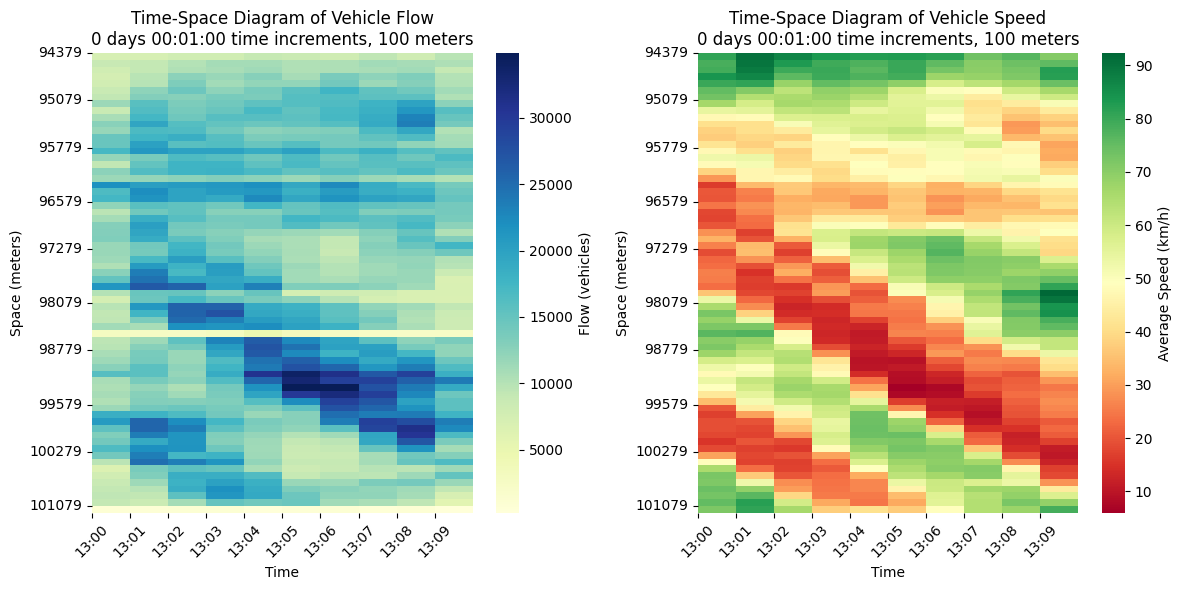

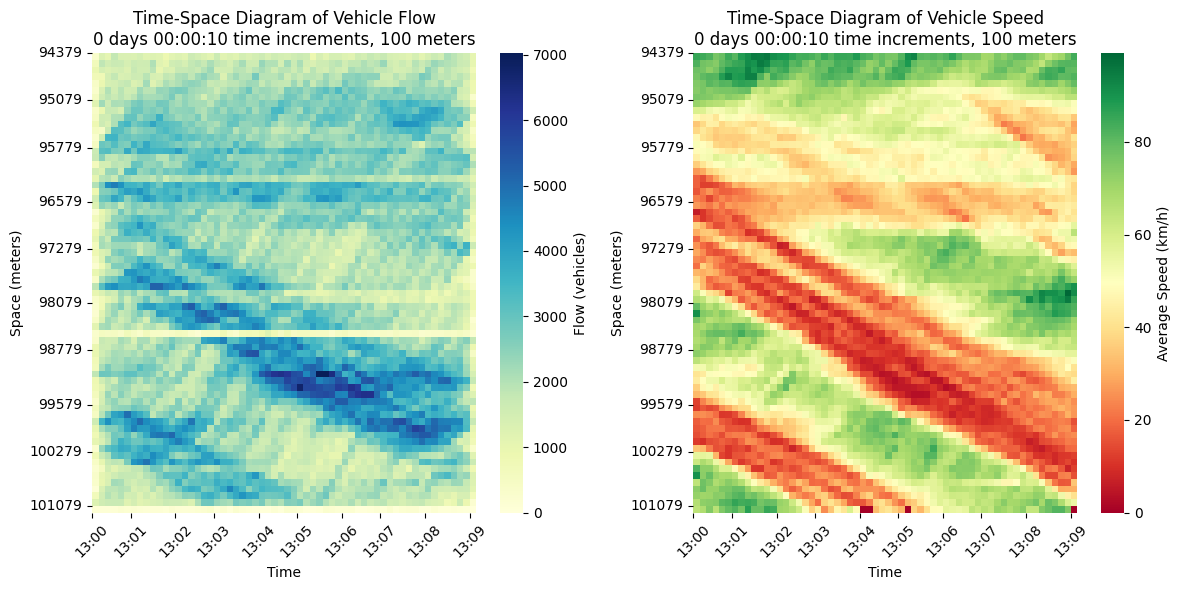

In [10]:
t_min, t_max = westbound_trajectories_10_mins_df["timestamp"].min(), westbound_trajectories_10_mins_df["timestamp"].max()
x_min, x_max = westbound_trajectories_10_mins_df["x_position"].min(), westbound_trajectories_10_mins_df["x_position"].max()
plot_matrices(flow_1min_100m, speed_1min_100m, pd.Timedelta(minutes=1), 100, t_min, t_max, x_min, x_max)
plot_matrices(flow_10sec_100m, speed_10sec_100m, pd.Timedelta(seconds=10), 100,  t_min, t_max, x_min, x_max)

In [11]:
input_filename = "6386d89efb3ff533c12df167__post10.json"
file_path = os.path.join("/Users/MonicaChan/Desktop/wu-lab/data_tutorial/11-30-2022/", input_filename)
westbound_trajectories_1_hr_df = load_trajectories(file_path, pd.Timedelta(hours=1), min_t)

Loaded 183187 westbound trajectories.
['trajectory_id', 'timestamp', 'x_position', 'speed']
          trajectory_id                     timestamp     x_position  \
0                     0 2022-11-30 13:00:00.400000095   98134.210938   
1                     0 2022-11-30 13:00:00.440000057   98133.351562   
2                     0 2022-11-30 13:00:00.480000019   98132.484375   
3                     0 2022-11-30 13:00:00.520000219   98131.609375   
4                     0 2022-11-30 13:00:00.560000181   98130.742188   
...                 ...                           ...            ...   
69230532         183186 2022-11-30 14:00:02.840000153  100646.125000   
69230533         183186 2022-11-30 14:00:02.880000114  100645.835938   
69230534         183186 2022-11-30 14:00:02.920000076  100645.554688   
69230535         183186 2022-11-30 14:00:02.960000038  100645.265625   
69230536         183186 2022-11-30 14:00:03.000000000  100644.968750   

              speed  
0               NaN  

In [12]:
# Save to csv
westbound_trajectories_1_hr_df.to_csv("data/westbound_trajectories_1_hr_df.csv")

In [13]:
flow_1min_100m_1hr, speed_1min_100m_1hr = get_flow_speed_matrix(westbound_trajectories_1_hr_df, time_interval = pd.Timedelta(minutes=1), space_interval = 100, output_filename="1min_100_m_flow_speed_1hr.csv")


CSV file saved as data/1min_100_m_flow_speed_1hr.csv


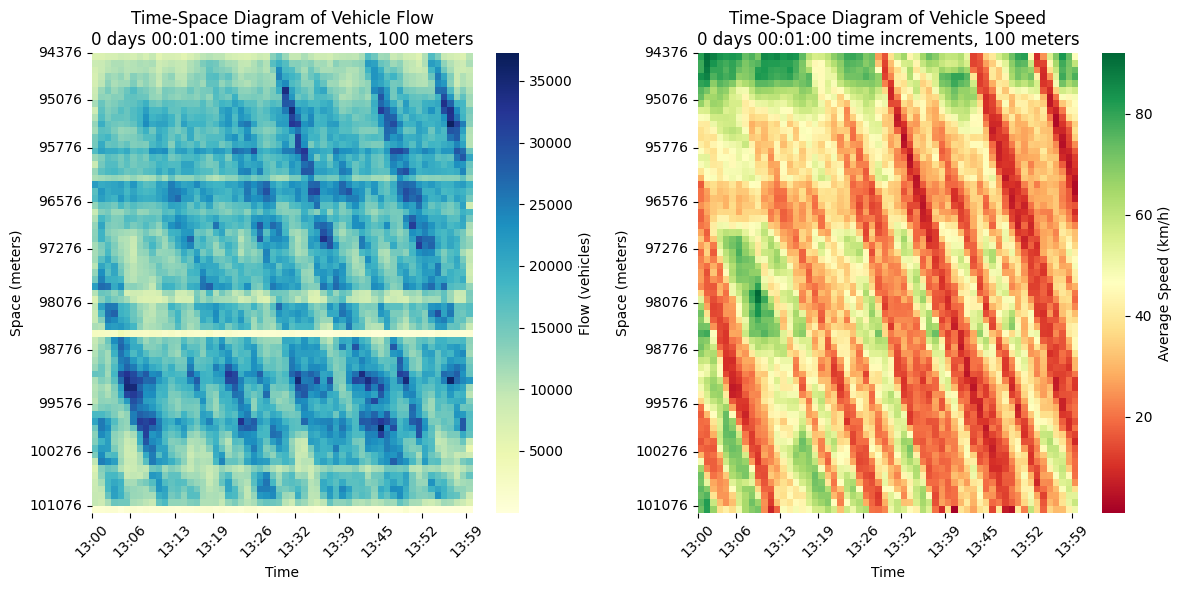

In [14]:
t_min, t_max = westbound_trajectories_1_hr_df["timestamp"].min(), westbound_trajectories_1_hr_df["timestamp"].max()
x_min, x_max = westbound_trajectories_1_hr_df["x_position"].min(), westbound_trajectories_1_hr_df["x_position"].max()
plot_matrices(flow_1min_100m_1hr, speed_1min_100m_1hr, pd.Timedelta(minutes=1), 100, t_min, t_max, x_min, x_max)


In [15]:
flow_10sec_100m_1hr, speed_10sec_100m_1hr = get_flow_speed_matrix(westbound_trajectories_1_hr_df, time_interval = pd.Timedelta(seconds=10), space_interval = 100, output_filename="10sec_100_m_flow_speed_1hr.csv")


CSV file saved as data/10sec_100_m_flow_speed_1hr.csv


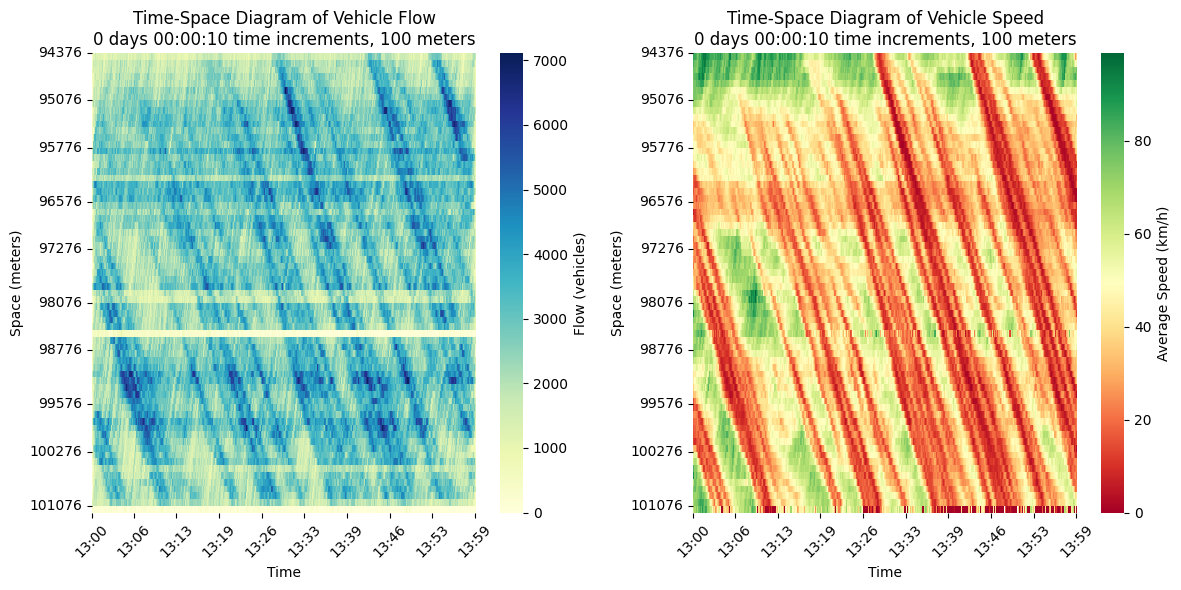

In [16]:
plot_matrices(flow_10sec_100m_1hr, speed_10sec_100m_1hr, pd.Timedelta(seconds=10), 100,  t_min, t_max, x_min, x_max)